# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [95]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [96]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        if self.w0 is None:
            self.w = np.random.rand(X.shape[1])
        else:
            self.w = self.w0

        for i in range(self.max_iter):
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                random_index = random.randint(0, X.shape[0] - 1)
                grad = self.calc_gradient(X[random_index : random_index + 1], y[random_index])
            else:
                raise Exception('Unknown gd_type')
            w_old = self.w.copy()
            self.w -= self.eta * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            # print(f"Iter {i}, loss: {loss}")
            if i % 500 == 0:
                print(f"Iter {i}, loss: {loss}")
            if np.linalg.norm(self.w - w_old) < self.tolerance:
                break
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        else:
            y_proba = 1 / (1 + np.exp(-X @ self.w))
            # two_dim_y_proba = np.array([1 - y_proba, y_proba]).T
            two_dim_y_proba = np.column_stack([1 - y_proba, y_proba])
            # return y_proba
            return two_dim_y_proba
        # pass


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        else:
            y_pred = np.where(self.predict_proba(X)[:, 1] >= 0.5, 1, 0)
            return y_pred
        # pass


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        y = np.atleast_1d(y) # если y — скаляр, он станет массивом формы (1,)
        n = X.shape[0]
        grad = (X.T @ (self.predict_proba(X)[:, 1] - y)) / n
        return grad
        # pass


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        proba = self.predict_proba(X)[:, 1]
        loss_cross_entropy = -np.mean(y * np.log(proba) + (1 - y) * np.log(1 - proba))
        return loss_cross_entropy
        # pass

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

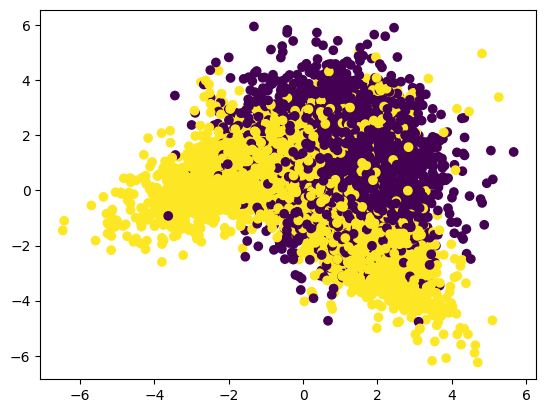

In [97]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

Iter 0, loss: 2.5122319701436395
Iter 500, loss: 0.4628842272511831


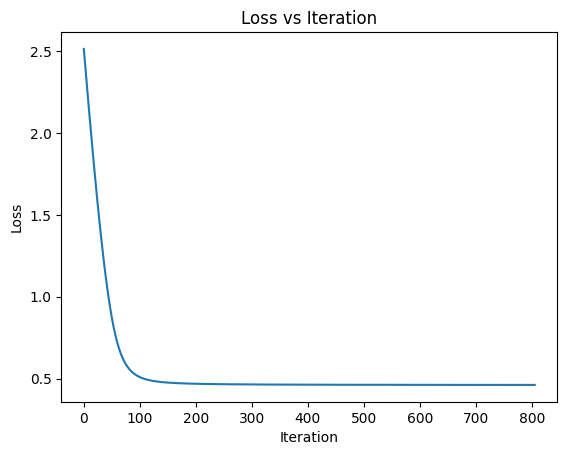

In [98]:
# your code
model = MyLogisticRegression(gd_type='full', tolerance=1e-4, max_iter=10000, eta=1e-2)
model.fit(X_train, y_train)

# print(model.loss_history)

plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

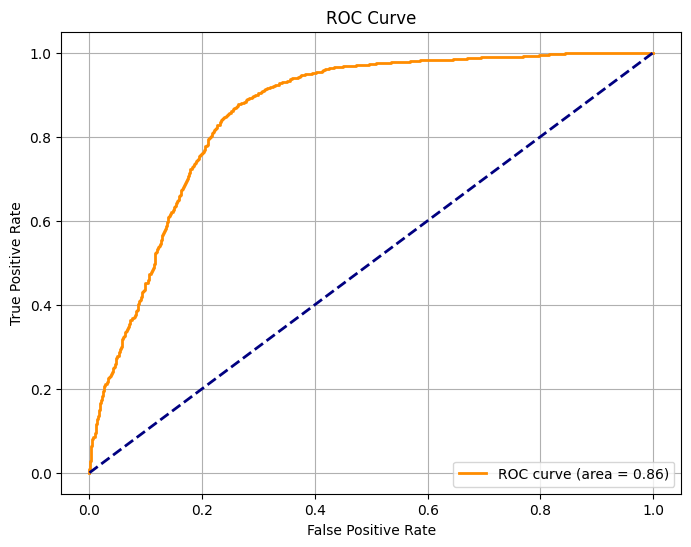

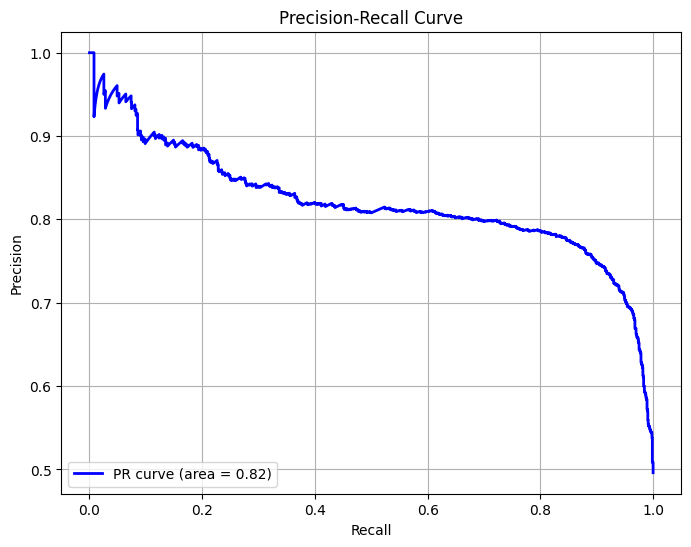

In [99]:
# your code
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, 1])
pr_auc = auc(recall, precision)

# ROC-кривая
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# PR-кривая
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [100]:
# kf = KFold(n_splits=5, shuffle=True, random_state=8)

# for i , j in kf.split(X):
#     print('---train---')
#     print(i, len(i))
#     print('---val---')
#     print(j, len(j))

In [101]:
# your code
kf = KFold(n_splits=5, shuffle=True, random_state=8)

roc_auc_scores = []
pr_auc_scores = []

for train_index, val_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    model = MyLogisticRegression(gd_type='full', tolerance=1e-4, max_iter=10000, eta=1e-2)
    model.fit(X_train, y_train)

    # y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    roc_auc = roc_auc_score(y_val, y_proba[:, 1])
    roc_auc_scores.append(roc_auc)

    precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

mean_roc_auc = np.mean(roc_auc_scores)
mean_pr_auc = np.mean(pr_auc_scores)
print('--------ROC-AUC--------')
print(f"Mean ROC-AUC: {mean_roc_auc:.4f}")
print('--------PR-AUC--------')
print(f"Mean PR-AUC: {mean_pr_auc:.4f}")

Iter 0, loss: 2.816188197565775
Iter 500, loss: 0.46958867620675765
Iter 0, loss: 2.8368372882315036
Iter 500, loss: 0.4633280758338038
Iter 0, loss: 2.3871003215281
Iter 500, loss: 0.4625627079383343
Iter 1000, loss: 0.4596309695509447
Iter 0, loss: 2.3192033920698294
Iter 500, loss: 0.4676360039514284
Iter 1000, loss: 0.4647490398372526
Iter 0, loss: 2.580667385407241
Iter 500, loss: 0.4679378420603949
Iter 1000, loss: 0.46355750450986044
--------ROC-AUC--------
Mean ROC-AUC: 0.8608
--------PR-AUC--------
Mean PR-AUC: 0.8318


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [102]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [103]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [104]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [105]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [106]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [111]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [112]:
y

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


In [107]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [132]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code
    if len(R) == 0:
        return float('inf')
    h = np.mean((R[:, -1] - np.mean(R[:, -1])) ** 2)
    return h


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    feature_idx = feature_names.index(feature)
    R_l = R_m[R_m[:, feature_idx] <= t]
    R_r = R_m[R_m[:, feature_idx] > t]
    return R_l, R_r


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
    R_l, R_r = split_node(R_m, feature, t)
    if len(R_l) == 0 or len(R_r) == 0:
        return float('inf')
    q = (len(R_l) / len(R_m)) * H(R_l) + (len(R_r) / len(R_m)) * H(R_r)
    return q


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

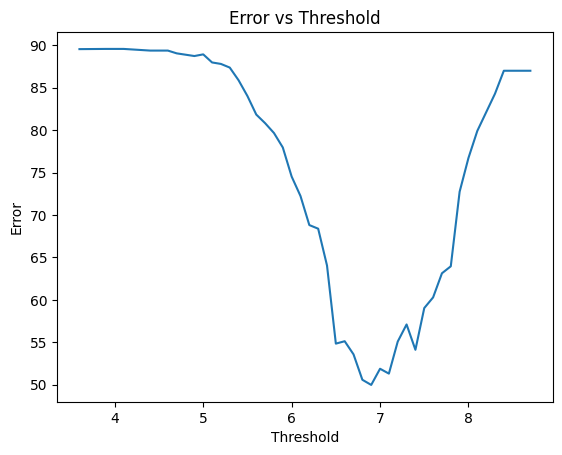

In [133]:
# your code
feature_rm = np.unique(round(X_train['RM'], 1))
feature_rm

errors = []
for i in feature_rm:
    errors.append(q_error(X_train.to_numpy(), 'RM', i))

plt.plot(feature_rm, errors)
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.title('Error vs Threshold')
plt.show()

In [134]:
best_idx = np.argmin(errors)
best_threshold = feature_rm[best_idx]
print(f"Best threshold: {best_threshold}, Min error: {errors[best_idx]:.2f}")

Best threshold: 6.9, Min error: 49.97


**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [139]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    feature_values = np.unique(np.round(R_m[:, feature_names.index(feature)], 1))
    errors = []
    for i in feature_values:
        errors.append(q_error(R_m, feature, i))
    best_idx = np.argmin(errors)
    best_threshold = feature_values[best_idx]
    return best_threshold, errors, feature_values

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [148]:
best_feature = None
best_threshold = None
best_error = float('inf')

for feature in feature_names:
    threshold, errors, feature_values = get_optimal_split(X_train.to_numpy(), feature)

    error = min(errors)

    if error < best_error:
        best_error = error
        best_feature = feature
        best_threshold = threshold

print(f"Best feature: {best_feature}")
print(f"Best threshold: {best_threshold}")
print(f"Best error: {best_error}")

Best feature: LSTAT
Best threshold: 9.6
Best error: 49.96417157935712


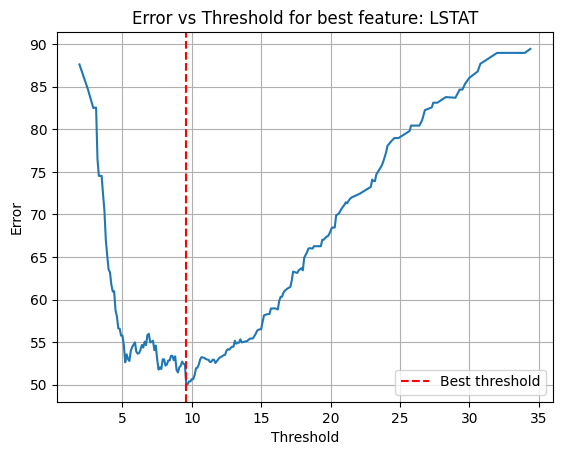

In [150]:
threshold, errors, feature_values = get_optimal_split(X_train.to_numpy(), best_feature)

plt.plot(feature_values, errors)
plt.axvline(best_threshold, color='red', linestyle='--', label='Best threshold')
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.title(f'Error vs Threshold for best feature: {best_feature}')
plt.legend()
plt.grid()
plt.show()

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

Text(0, 0.5, 'target')

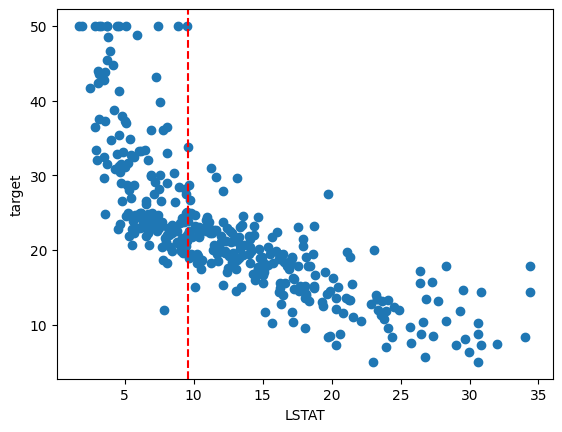

In [151]:
# your code
plt.scatter(X_train[best_feature], X_train['target'])
plt.axvline(best_threshold, color='red', linestyle='--', label='Best threshold')
plt.xlabel(best_feature)
plt.ylabel('target')